# RNN Network on Predicting Stock Price



In [1]:
########Load required Modules
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import time
######import functions 
import torch.nn.functional as F
from torch.autograd import Variable
import sklearn.metrics as sm
###### Set device: GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

## 数据预览

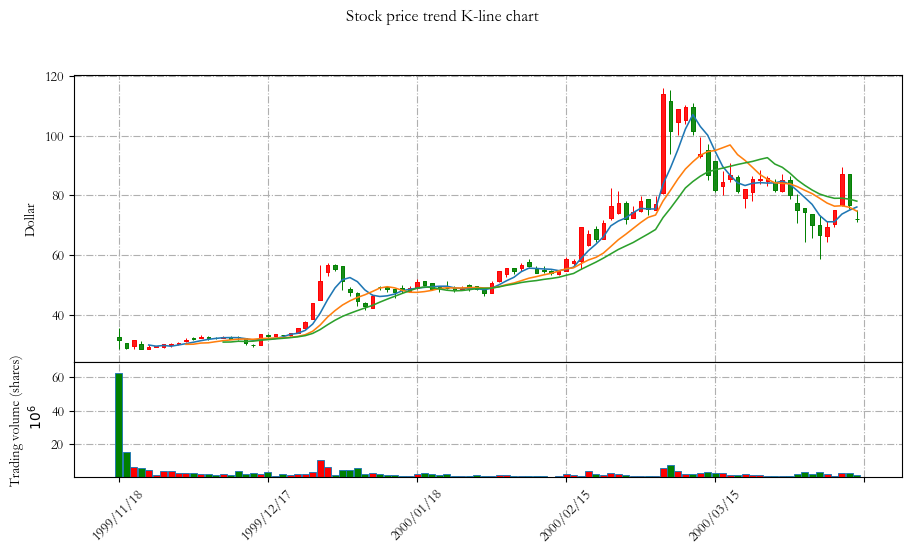

In [3]:
# 我们额外训练集A的前100条数据
# 绘制股价走势日k线图
import pandas as pd
import mplfinance as mpf
data = pd.read_csv(r'Y:\HOMEWORK\archive\stocks\A.csv').iloc[:100,:]  # 传入数据
data['Date'] = pd.to_datetime(data['Date'])
# 01. 构建数据集
data_Kline0 = pd.DataFrame(
    {
        'date': data['Date'],
        'open': data['Open'],
        'high': data['High'],
        'low': data['Low'],
        'close': data['Close'],
        'volume': data['Volume']
    }
)
data_Kline = data_Kline0.set_index('date')  # 以日期为索引

# 02. 设置K线样式
my_color = mpf.make_marketcolors(
    up='red',
    down='green',
    edge='inherit',
    wick='i',  # wick:上下影线颜色,i表示继承up和down的颜色
    volume={'up': 'red', 'down': 'green'},  # 成交量直方图颜色，也可用i继承up和down的颜色
    ohlc='i'
)
my_style = mpf.make_mpf_style(
    marketcolors=my_color,  # 设置图表显示配色 mpf.available_styles() 可以查看所有样式
    gridaxis='both',  # 设置网格位置
    gridstyle='-.',  # 设置网格线线型
    rc={'font.family': 'STSong'}  # 设置中文兼容
)

# 03. 绘图
mpf.plot(
    data_Kline,
    type='candle',  # 设置显示样式 选项['ohlc','candle','line','renko','pnf']
    title='Stock price trend K-line chart',  # 设置图标题
    ylabel='Dollar',  # 设置y轴标题
    style=my_style,  # 应用上面命令设置的样式
    show_nontrading=False,  # 是否显示非交易日，默认为False:显示
    volume=True,  # 下方是否显示成交量，默认为False
    ylabel_lower='Trading volume (shares)',  # 成交量图的Y轴标题
    datetime_format='%Y/%m/%d',  # x轴的时间显示格式
    xrotation=45,  # x轴的时间坐标旋转角度
    linecolor='#00ff00',  # 若type='line'设置线条颜色
    figratio=(20,10),
    mav=(5,10,15), # 平均线
    tight_layout=False  # 是否紧密显示
)


C:\Users\kh139\.conda\envs\graduate\lib\site-packages\mplfinance\_arg_validators.py:94: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


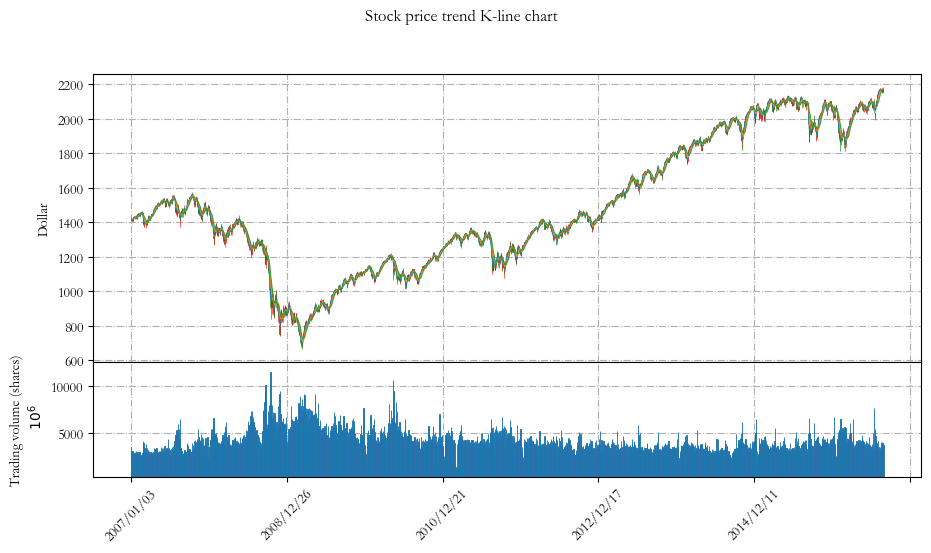

In [34]:
# 这是老师的训练集！！
data = pd.read_csv("dataset/train.csv")  # 传入数据
data['Date'] = pd.to_datetime(data['Date'])
# 01. 构建数据集
data_Kline0 = pd.DataFrame(
    {
        'date': data['Date'],
        'open': data['Open'],
        'high': data['High'],
        'low': data['Low'],
        'close': data['Close'],
        'volume': data['Volume']
    }
)
data_Kline = data_Kline0.set_index('date')  # 以日期为索引

# 02. 设置K线样式
my_color = mpf.make_marketcolors(
    up='red',
    down='green',
    edge='inherit',
    wick='i',  # wick:上下影线颜色,i表示继承up和down的颜色
    volume={'up': 'red', 'down': 'green'},  # 成交量直方图颜色，也可用i继承up和down的颜色
    ohlc='i'
)
my_style = mpf.make_mpf_style(
    marketcolors=my_color,  # 设置图表显示配色 mpf.available_styles() 可以查看所有样式
    gridaxis='both',  # 设置网格位置
    gridstyle='-.',  # 设置网格线线型
    rc={'font.family': 'STSong'}  # 设置中文兼容
)

# 03. 绘图
mpf.plot(
    data_Kline,
    type='candle',  # 设置显示样式 选项['ohlc','candle','line','renko','pnf']
    title='Stock price trend K-line chart',  # 设置图标题
    ylabel='Dollar',  # 设置y轴标题
    style=my_style,  # 应用上面命令设置的样式
    show_nontrading=False,  # 是否显示非交易日，默认为False:显示
    volume=True,  # 下方是否显示成交量，默认为False
    ylabel_lower='Trading volume (shares)',  # 成交量图的Y轴标题
    datetime_format='%Y/%m/%d',  # x轴的时间显示格式
    xrotation=45,  # x轴的时间坐标旋转角度
    linecolor='#00ff00',  # 若type='line'设置线条颜色
    figratio=(20,10),
    mav=(5,10,15), # 平均线
    tight_layout=False  # 是否紧密显示
)

## 函数准备

In [47]:
#反归一化函数
def inverse_transform(maxmin,data):
    new = data*maxmin.data_range_[-1]+maxmin.data_min_[-1]
    return new

In [48]:
#数据集的生成代码
def gdata(window,data):
    #原数据标准化
    train = MinMaxScaler(feature_range =(0.01, 1))
    dataset_scaled = train.fit_transform(data.values)
    
    y_newdata = data.iloc[1:,-1].values/data.iloc[:-1,-1].values -1

    x1 = []
    x2 = []
    y1 = []
    y2 = []
    for index in range(len(dataset_scaled) - window):
        need_data = dataset_scaled[index: index + window]
        x1.append(need_data[:-1,:])
        x2.append(y_newdata[index:index + window-2]) # 这是提升幅度只有19行
        y1.append(need_data[-1,-1])
        y2.append(y_newdata[index + window-1])

    y1 = np.array(y1).reshape(-1,1)    
    y2 = np.array(y2).reshape(-1,1)    
    y = np.hstack([y1,y2])   
    
    x1 = np.array(x1).reshape(y.shape[0],-1)
    x2 = np.array(x2).reshape(y.shape[0],-1)
    x = np.hstack([x1,x2])
    return(x, y, train)


In [49]:
# mse的函数代码
def my_loss_fn(y_pred, y_true):
    loss = (y_true-y_pred)**2
    return torch.mean(loss)

In [50]:
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer

def loss_test(lossf,unsupervised_model):
    max_epochs = 40
    model = TabNetRegressor(#cat_dims=cat_dims,
                            #cat_emb_dim=cat_emb_dim,
                            #cat_idxs=cat_idxs
                            optimizer_fn=torch.optim.Adam, # Any optimizer works here
                            optimizer_params=dict(lr=1e-2),
                            mask_type='entmax' # "sparsemax"
                           )

    model.fit(
        newx_train, newy_train,
        eval_set=[(x_val, y_val)],
        #eval_metric=[Gini]
        batch_size = 128,
        max_epochs=max_epochs ,
        loss_fn=lossf,
        eval_metric=['mse', 'mae', 'rmse',],
        from_unsupervised=unsupervised_model
    )
    return model

## 原数据导入

In [51]:
# Train
dataset_train = pd.read_csv("dataset/train.csv")
dataset_train['Date'] = pd.to_datetime(dataset_train['Date'])
dataset_train = dataset_train[['Open','High','Low','Close']]
# Val
dataset_val = pd.read_csv("dataset/val.csv")
dataset_val['Date'] = pd.to_datetime(dataset_val['Date'])
dataset_val = dataset_val[['Open','High','Low','Close']]


In [52]:
x_train, y_train, scaler_train = gdata(21,dataset_train)
x_val, y_val, scaler_val = gdata(21,dataset_val)

## 无监督预训练(需要获取任意一个数据集才可以运行)

In [54]:
# 无监督训练
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax"
)

unsupervised_model.fit(
    X_train=newx_train,
    #eval_set=[newy_train],
    pretraining_ratio=0.5,
)

# save tabnet model
#saving_path_name = "./unsupervised_model"
#saved_filepath = unsupervised_model.save_model(saving_path_name)

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 514.27895|  0:00:01s
epoch 1  | loss: 10.52222|  0:00:02s
epoch 2  | loss: 1.2536  |  0:00:04s
epoch 3  | loss: 0.53529 |  0:00:05s
epoch 4  | loss: 0.39819 |  0:00:07s
epoch 5  | loss: 0.3555  |  0:00:08s
epoch 6  | loss: 0.31382 |  0:00:09s
epoch 7  | loss: 0.29892 |  0:00:10s
epoch 8  | loss: 0.29208 |  0:00:12s
epoch 9  | loss: 0.2897  |  0:00:13s
epoch 10 | loss: 0.29169 |  0:00:14s
epoch 11 | loss: 0.2866  |  0:00:16s
epoch 12 | loss: 0.27942 |  0:00:17s
epoch 13 | loss: 0.26694 |  0:00:18s
epoch 14 | loss: 0.25924 |  0:00:19s
epoch 15 | loss: 0.26495 |  0:00:21s
epoch 16 | loss: 0.26566 |  0:00:22s
epoch 17 | loss: 0.25787 |  0:00:23s
epoch 18 | loss: 0.25597 |  0:00:24s
epoch 19 | loss: 0.26123 |  0:00:26s
epoch 20 | loss: 0.25614 |  0:00:27s
epoch 21 | loss: 0.25989 |  0:00:28s
epoch 22 | loss: 0.25172 |  0:00:29s
epoch 23 | loss: 0.24733 |  0:00:30s
epoch 24 | loss: 0.24975 |  0:00:31s
epoch 25 | loss: 0.25338 |  0:00:33s
epoch 26 | loss: 0.25132 |  0:00:34s


In [55]:
# define new model with basic parameters and load state dict weights
unsupervised_model = TabNetPretrainer()
unsupervised_model.load_model(r"Y:\HOMEWORK\FinalProjectDemo\unsupervised_model.zip")

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


## 训练集的生成(无原数据)

In [56]:
data = pd.read_csv(r'Y:\HOMEWORK\archive\stocks\A.csv')
new_train = data[['Open','High','Low','Close']]
newx_train, newy_train, train = gdata(21,new_train)
print(newx_train.shape)
for i in ['AA','AACG']:
    df = pd.read_csv(r'Y:\HOMEWORK\archive\stocks\{}.csv'.format(i), parse_dates=['Date'])
    new_train = df[['Open','High','Low','Close']]
    A,B,C = gdata(21,new_train)
    print(A.shape)
    newx_train = np.vstack([newx_train,A])
    newy_train = np.vstack([newy_train,B])
print('总数据量',newx_train.shape)
newx_train.shape,newy_train.shape

(5103, 99)
(14642, 99)
(240, 99)
总数据量 (19985, 99)


((19985, 99), (19985, 2))

In [57]:
model = loss_test(my_loss_fn,unsupervised_model)

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.17489 | val_0_mse: 0.01214 | val_0_mae: 0.06562 | val_0_rmse: 0.1102  |  0:00:04s
epoch 1  | loss: 0.0029  | val_0_mse: 0.00342 | val_0_mae: 0.03799 | val_0_rmse: 0.05846 |  0:00:08s
epoch 2  | loss: 0.00226 | val_0_mse: 0.00264 | val_0_mae: 0.03164 | val_0_rmse: 0.05142 |  0:00:12s
epoch 3  | loss: 0.00168 | val_0_mse: 0.00211 | val_0_mae: 0.03171 | val_0_rmse: 0.04596 |  0:00:16s
epoch 4  | loss: 0.00163 | val_0_mse: 0.00355 | val_0_mae: 0.03947 | val_0_rmse: 0.05954 |  0:00:21s
epoch 5  | loss: 0.00145 | val_0_mse: 0.00188 | val_0_mae: 0.02991 | val_0_rmse: 0.04331 |  0:00:25s
epoch 6  | loss: 0.00155 | val_0_mse: 0.00221 | val_0_mae: 0.03149 | val_0_rmse: 0.04698 |  0:00:29s
epoch 7  | loss: 0.00136 | val_0_mse: 0.00197 | val_0_mae: 0.03057 | val_0_rmse: 0.04433 |  0:00:33s
epoch 8  | loss: 0.00126 | val_0_mse: 0.00165 | val_0_mae: 0.02748 | val_0_rmse: 0.04067 |  0:00:38s
epoch 9  | loss: 0.00133 | val_0_mse: 0.00188 | val_0_mae: 0.02634 | val_0_rmse: 0.04335 | 

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [58]:
y_train_model = inverse_transform(scaler_train,model.predict(x_train)[:,0].reshape(-1,1))
y_train_original = inverse_transform(scaler_train, y_train[:,0].reshape(-1,1))

y_val_pred = model.predict(x_val)[:,0].reshape(-1,1)
y_val_model = inverse_transform(scaler_val, y_val_pred)
y_val_original = inverse_transform(scaler_val, y_val[:,0].reshape(-1,1))

## 训练集的生成(只有原数据)

In [59]:
newx_train, newy_train, train = gdata(21,dataset_train)
model0 = loss_test(my_loss_fn,unsupervised_model)

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 1.38959 | val_0_mse: 1.08293 | val_0_mae: 0.66258 | val_0_rmse: 1.04064 |  0:00:00s
epoch 1  | loss: 0.03903 | val_0_mse: 0.95314 | val_0_mae: 0.55686 | val_0_rmse: 0.97629 |  0:00:01s
epoch 2  | loss: 0.00876 | val_0_mse: 0.36831 | val_0_mae: 0.35043 | val_0_rmse: 0.60689 |  0:00:01s
epoch 3  | loss: 0.00633 | val_0_mse: 0.1524  | val_0_mae: 0.23022 | val_0_rmse: 0.39039 |  0:00:01s
epoch 4  | loss: 0.00444 | val_0_mse: 0.07716 | val_0_mae: 0.17474 | val_0_rmse: 0.27778 |  0:00:02s
epoch 5  | loss: 0.00368 | val_0_mse: 0.04564 | val_0_mae: 0.13182 | val_0_rmse: 0.21363 |  0:00:03s
epoch 6  | loss: 0.00289 | val_0_mse: 0.02344 | val_0_mae: 0.09057 | val_0_rmse: 0.15309 |  0:00:03s
epoch 7  | loss: 0.00269 | val_0_mse: 0.02175 | val_0_mae: 0.08996 | val_0_rmse: 0.14749 |  0:00:04s
epoch 8  | loss: 0.00251 | val_0_mse: 0.01214 | val_0_mae: 0.06685 | val_0_rmse: 0.11018 |  0:00:04s
epoch 9  | loss: 0.00247 | val_0_mse: 0.00671 | val_0_mae: 0.04926 | val_0_rmse: 0.08194 | 

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [60]:
y_train_model0 = inverse_transform(scaler_train,model0.predict(x_train)[:,0].reshape(-1,1))

y_val_pred0 = model0.predict(x_val)[:,0].reshape(-1,1)
y_val_model0 = inverse_transform(scaler_val, y_val_pred0)

## 训练集的生成(有原数据)

In [61]:
newx_train, newy_train, train = gdata(21,dataset_train)
print(newx_train.shape)
for i in ['A','AA','AACG']:
    df = pd.read_csv(r'Y:\HOMEWORK\archive\stocks\{}.csv'.format(i), parse_dates=['Date'])
    new_train = df[['Open','High','Low','Close']]
    A,B,C = gdata(21,new_train)
    print(A.shape)
    newx_train = np.vstack([newx_train,A])
    newy_train = np.vstack([newy_train,B])
print('总数据量',newx_train.shape)
newx_train.shape,newy_train.shape

(2395, 99)
(5103, 99)
(14642, 99)
(240, 99)
总数据量 (22380, 99)


((22380, 99), (22380, 2))

In [62]:
model1 = loss_test(my_loss_fn,unsupervised_model)

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.15788 | val_0_mse: 0.01988 | val_0_mae: 0.08062 | val_0_rmse: 0.14099 |  0:00:04s
epoch 1  | loss: 0.00326 | val_0_mse: 0.0084  | val_0_mae: 0.05964 | val_0_rmse: 0.09163 |  0:00:09s
epoch 2  | loss: 0.00231 | val_0_mse: 0.00638 | val_0_mae: 0.04878 | val_0_rmse: 0.07989 |  0:00:13s
epoch 3  | loss: 0.00177 | val_0_mse: 0.00283 | val_0_mae: 0.03109 | val_0_rmse: 0.05324 |  0:00:18s
epoch 4  | loss: 0.00157 | val_0_mse: 0.00305 | val_0_mae: 0.03423 | val_0_rmse: 0.0552  |  0:00:23s
epoch 5  | loss: 0.00154 | val_0_mse: 0.00338 | val_0_mae: 0.03294 | val_0_rmse: 0.05817 |  0:00:27s
epoch 6  | loss: 0.00166 | val_0_mse: 0.00414 | val_0_mae: 0.04239 | val_0_rmse: 0.06436 |  0:00:32s
epoch 7  | loss: 0.00134 | val_0_mse: 0.00347 | val_0_mae: 0.0335  | val_0_rmse: 0.05888 |  0:00:37s
epoch 8  | loss: 0.00138 | val_0_mse: 0.00495 | val_0_mae: 0.04347 | val_0_rmse: 0.07038 |  0:00:41s
epoch 9  | loss: 0.0012  | val_0_mse: 0.00165 | val_0_mae: 0.02877 | val_0_rmse: 0.04064 | 

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 数据结果可视化

In [63]:
y_train_model1 = inverse_transform(scaler_train,model1.predict(x_train)[:,0].reshape(-1,1))

y_val_pred1 = model1.predict(x_val)[:,0].reshape(-1,1)
y_val_model1 = inverse_transform(scaler_val, y_val_pred1)

<Figure size 2560x1920 with 0 Axes>

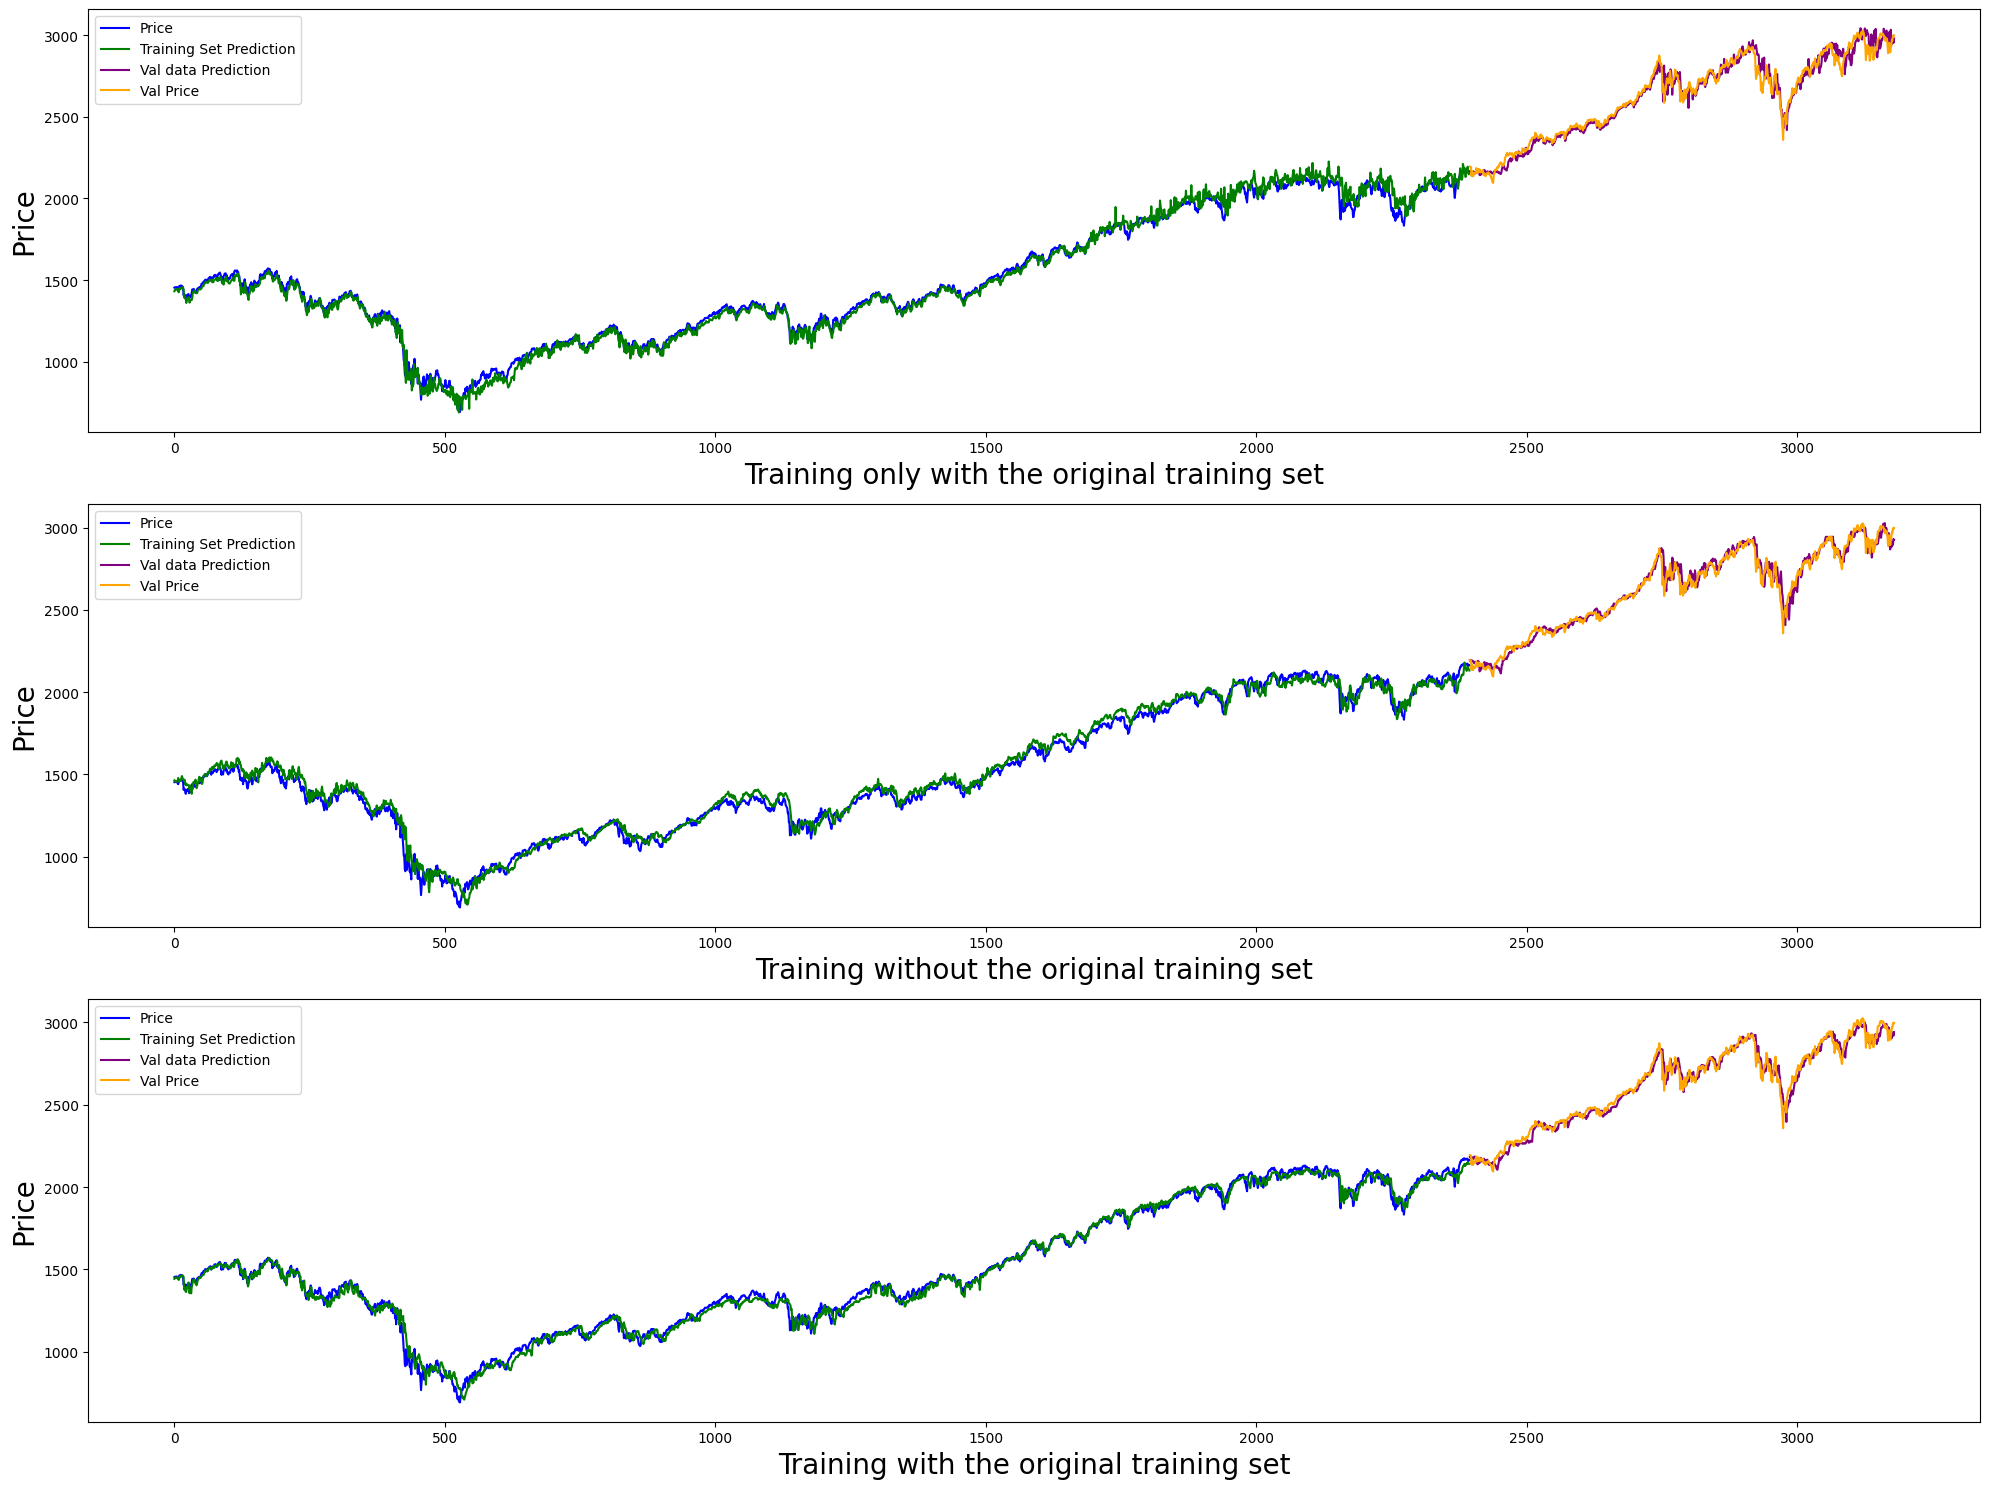

In [64]:
######visualization for single test
N_original,N_val = len(y_train_original),len(y_val_model)
index_val = [i for i in range(0,N_val)]
index_val = np.array(index_val).reshape(-1,1) + N_original

## Show all curve

plt.figure(dpi=400)
plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)

plt.plot(y_train_original, color = 'blue', label = 'Price')
plt.plot(y_train_model0, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Training only with the original training set',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.plot(index_val, y_val_model0, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, y_val_original, color = 'orange', label = 'Val Price')
plt.legend()

plt.subplot(3, 1, 2)

plt.plot(y_train_original, color = 'blue', label = 'Price')
plt.plot(y_train_model, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Training without the original training set',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.plot(index_val, y_val_model, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, y_val_original, color = 'orange', label = 'Val Price')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(y_train_original, color = 'blue', label = 'Price')
plt.plot(y_train_model1, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Training with the original training set',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.plot(index_val, y_val_model1, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, y_val_original, color = 'orange', label = 'Val Price')
plt.legend()
plt.tight_layout()
plt.show()

## 结果评测

In [65]:
def metmodel(y_ture,y_pre):
    print("MSE:{}".format(sm.mean_squared_error(y_ture,y_pre)))
    print("MAE:{}".format(sm.mean_absolute_error(y_ture,y_pre)))
    print("RMSE:{}".format(np.sqrt(sm.mean_squared_error(y_ture,y_pre))))
    print("R-Square:{}".format(sm.r2_score(y_ture,y_pre)))
    E = y_ture-y_pre
    DW = np.sum((E[1:]-E[:-1])**2)/np.sum(E[1:]**2)
    print("D:{}".format(DW))
y_train_original = inverse_transform(scaler_train, y_train[:,0].reshape(-1,1))
metmodel(y_train_original,y_train_model1)

MSE:1102.892411088924
MAE:24.78746233735849
RMSE:33.20982401472378
R-Square:0.9921188400337588
D:0.45342169835952123


In [66]:
def my_loss_fn1(y_pred, y_true):
    alpha = 2
    loss = (y_pred[:,0] - y_true[:,0])**2
    adj = torch.mul(y_pred[:,1], y_true[:,1])
    adj[adj>0] = 1 / alpha
    adj[adj<0] = alpha
    loss = loss * adj
    return torch.mean(loss)
modelloss1 = loss_test(my_loss_fn1,unsupervised_model)

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.39812 | val_0_mse: 3.14556 | val_0_mae: 1.08424 | val_0_rmse: 1.77357 |  0:00:04s
epoch 1  | loss: 0.00518 | val_0_mse: 2.59921 | val_0_mae: 0.96923 | val_0_rmse: 1.61221 |  0:00:09s
epoch 2  | loss: 0.00334 | val_0_mse: 2.63542 | val_0_mae: 0.96772 | val_0_rmse: 1.6234  |  0:00:14s
epoch 3  | loss: 0.00231 | val_0_mse: 2.52743 | val_0_mae: 0.95542 | val_0_rmse: 1.58979 |  0:00:18s
epoch 4  | loss: 0.00204 | val_0_mse: 2.64347 | val_0_mae: 0.97387 | val_0_rmse: 1.62588 |  0:00:23s
epoch 5  | loss: 0.00239 | val_0_mse: 2.71817 | val_0_mae: 1.0215  | val_0_rmse: 1.64869 |  0:00:28s
epoch 6  | loss: 0.0025  | val_0_mse: 2.62975 | val_0_mae: 0.96999 | val_0_rmse: 1.62165 |  0:00:32s
epoch 7  | loss: 0.00156 | val_0_mse: 2.7051  | val_0_mae: 0.97503 | val_0_rmse: 1.64472 |  0:00:37s
epoch 8  | loss: 0.00219 | val_0_mse: 2.53756 | val_0_mae: 0.95209 | val_0_rmse: 1.59297 |  0:00:41s
epoch 9  | loss: 0.00181 | val_0_mse: 2.37089 | val_0_mae: 0.92222 | val_0_rmse: 1.53977 | 

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [74]:
y_train_loss1 = inverse_transform(scaler_train,modelloss1.predict(x_train)[:,0].reshape(-1,1))

metmodel(y_train_original,y_train_loss1)

MSE:511.68303412768535
MAE:18.013597981685837
RMSE:22.62041189120316
R-Square:0.996343563702655
D:0.917189116008085


In [68]:
#非常不好函数,有e^10000使我的cuda受伤。

'''def my_loss_fn2(y_pred, y_true):
    beta = 2.5
    loss1 = (y_pred - y_true)**2
    adj_loss = beta - (beta - 0.5) / (1 + torch.exp(10000 * torch.mul(y_pred, y_true)))
    loss = beta * loss1 /(1+adj_loss) 
    return torch.mean(loss)

modelloss2 = loss_test(my_loss_fn2,unsupervised_model)
y_train_loss2 = inverse_transform(scaler_train,modelloss2.predict(x_train)[:,0].reshape(-1,1))

metmodel(y_train_original,y_train_loss2)

y_train_loss2 = inverse_transform(scaler_train,modelloss2.predict(x_train)[:,0].reshape(-1,1))

metmodel(y_train_original,y_train_loss2)
'''

'def my_loss_fn2(y_pred, y_true):\n    beta = 2.5\n    loss1 = (y_pred - y_true)**2\n    adj_loss = beta - (beta - 0.5) / (1 + torch.exp(10000 * torch.mul(y_pred, y_true)))\n    loss = beta * loss1 /(1+adj_loss) \n    return torch.mean(loss)\n\nmodelloss2 = loss_test(my_loss_fn2,unsupervised_model)\ny_train_loss2 = inverse_transform(scaler_train,modelloss2.predict(x_train)[:,0].reshape(-1,1))\n\nmetmodel(y_train_original,y_train_loss2)\n\ny_train_loss2 = inverse_transform(scaler_train,modelloss2.predict(x_train)[:,0].reshape(-1,1))\n\nmetmodel(y_train_original,y_train_loss2)\n'

In [69]:
def my_loss_fn3(y_pred, y_true):
    gamma = 0.1
    loss = (y_pred[:,0] - y_true[:,0])**2
    adj = torch.mul(y_pred[:,1], y_true[:,1])
    adj[adj>0] = gamma
    adj[adj<0] = 1 + gamma
    loss = loss * adj
    return torch.mean(loss)
modelloss3 = loss_test(my_loss_fn3,unsupervised_model)

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.18944 | val_0_mse: 2.60928 | val_0_mae: 1.00847 | val_0_rmse: 1.61533 |  0:00:04s
epoch 1  | loss: 0.00255 | val_0_mse: 2.13493 | val_0_mae: 0.90602 | val_0_rmse: 1.46114 |  0:00:09s
epoch 2  | loss: 0.00207 | val_0_mse: 2.15953 | val_0_mae: 0.9165  | val_0_rmse: 1.46953 |  0:00:14s
epoch 3  | loss: 0.0016  | val_0_mse: 2.29206 | val_0_mae: 0.91564 | val_0_rmse: 1.51395 |  0:00:18s
epoch 4  | loss: 0.00144 | val_0_mse: 2.13281 | val_0_mae: 0.89401 | val_0_rmse: 1.46041 |  0:00:23s
epoch 5  | loss: 0.00154 | val_0_mse: 1.73609 | val_0_mae: 0.83322 | val_0_rmse: 1.31761 |  0:00:27s
epoch 6  | loss: 0.00145 | val_0_mse: 1.47056 | val_0_mae: 0.76853 | val_0_rmse: 1.21267 |  0:00:32s
epoch 7  | loss: 0.00116 | val_0_mse: 1.66411 | val_0_mae: 0.79883 | val_0_rmse: 1.29    |  0:00:37s
epoch 8  | loss: 0.00139 | val_0_mse: 1.51183 | val_0_mae: 0.77236 | val_0_rmse: 1.22956 |  0:00:41s
epoch 9  | loss: 0.00126 | val_0_mse: 1.55139 | val_0_mae: 0.7717  | val_0_rmse: 1.24555 | 

C:\Users\kh139\.conda\envs\graduate\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [72]:
y_train_loss3 = inverse_transform(scaler_train,modelloss3.predict(x_train)[:,0].reshape(-1,1))

metmodel(y_train_original,y_train_loss3)

MSE:4044.900534062717
MAE:44.43277099787769
RMSE:63.599532498774835
R-Square:0.9710955412912783
D:0.10855019620176554


In [73]:
torch.save(model1, 'tabnet.pth')
torch.save(modelloss1, 'tabnet1.pth')
torch.save(modelloss3, 'tabnet3.pth')

# Evaluate the model

In [75]:
########Load pretrain model
final_model = torch.load('tabnet.pth')
final_model.network

y_train_model = inverse_transform(scaler_train,final_model.predict(x_train)[:,0].reshape(-1,1))
y_train_original = inverse_transform(scaler_train, y_train[:,0].reshape(-1,1))

y_val_pred = final_model.predict(x_val)[:,0].reshape(-1,1)
y_val_model = inverse_transform(scaler_val, y_val_pred)
y_val_original = inverse_transform(scaler_val, y_val[:,0].reshape(-1,1))

In [76]:
########Load pretrain model
final_model = torch.load('tabnet1.pth')
final_model.network

y_t1 = inverse_transform(scaler_train,final_model.predict(x_train)[:,0].reshape(-1,1))

y_val_pred = final_model.predict(x_val)[:,0].reshape(-1,1)
y1 = inverse_transform(scaler_val, y_val_pred)

In [77]:
########Load pretrain model
model = torch.load('tabnet3.pth')
model.network

y_t3 = inverse_transform(scaler_train,model.predict(x_train)[:,0].reshape(-1,1))

y_val_pred = final_model.predict(x_val)[:,0].reshape(-1,1)
y3 = inverse_transform(scaler_val, y_val_pred)

# Visualization

<Figure size 2560x1920 with 0 Axes>

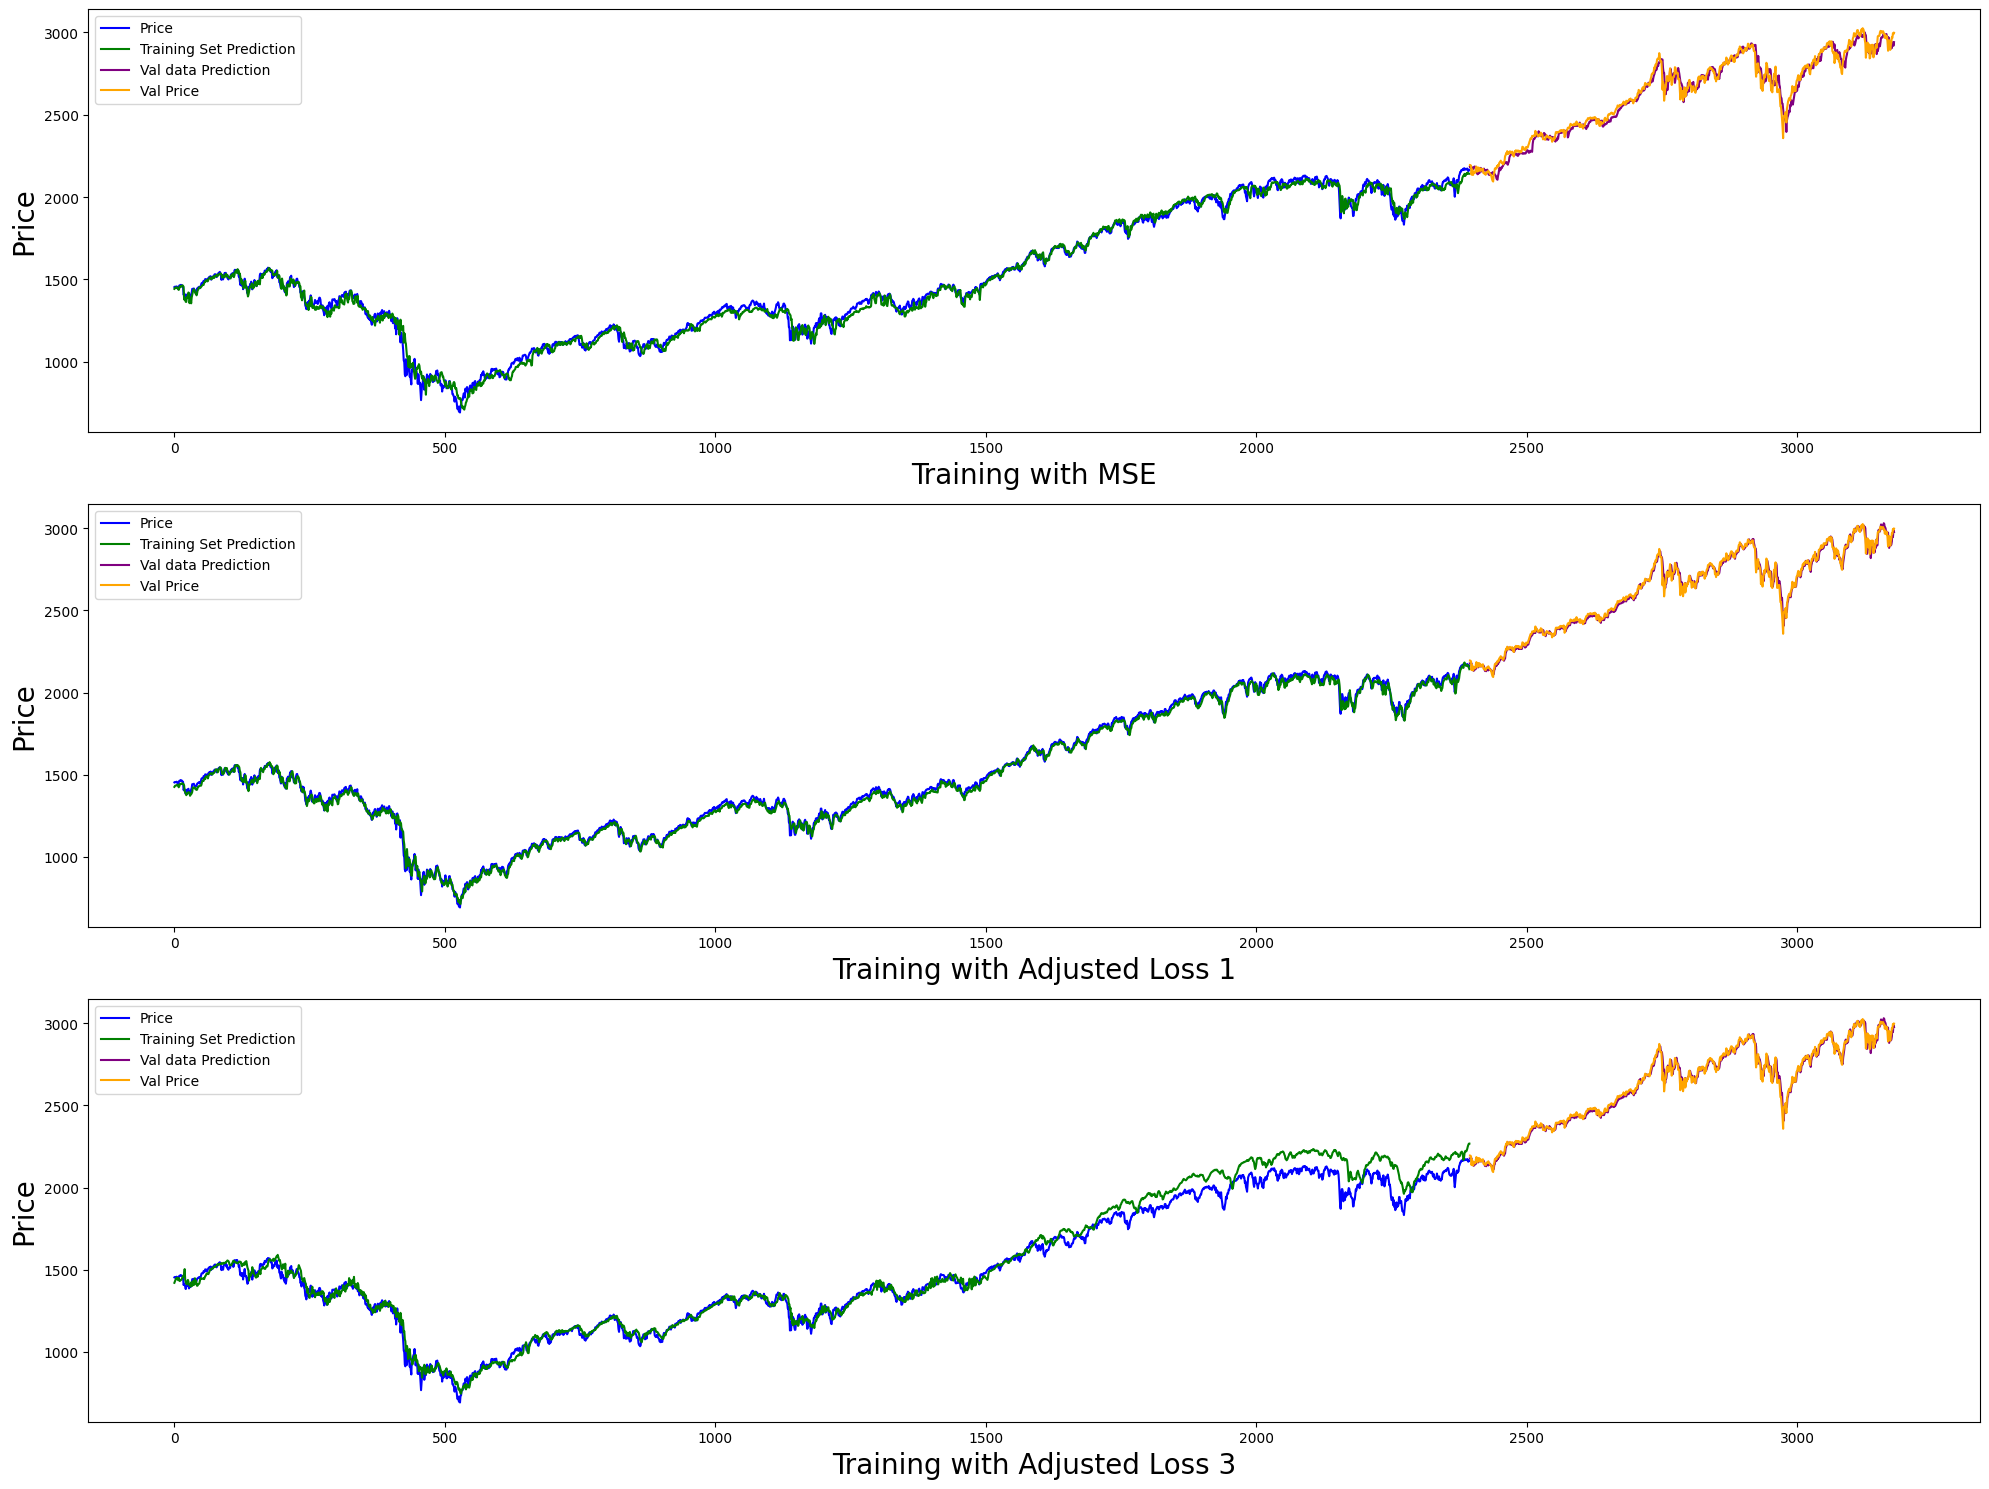

In [78]:
######visualization for single test
N_original,N_val = len(y_train_original),len(y_val_model)
index_val = [i for i in range(0,N_val)]
index_val = np.array(index_val).reshape(-1,1) + N_original

## Show all curve

plt.figure(dpi=400)
plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)

plt.plot(y_train_original, color = 'blue', label = 'Price')
plt.plot(y_train_model, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Training with MSE',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.plot(index_val, y_val_model, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, y_val_original, color = 'orange', label = 'Val Price')
plt.legend()

plt.subplot(3, 1, 2)

plt.plot(y_train_original, color = 'blue', label = 'Price')
plt.plot(y_t1, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Training with Adjusted Loss 1',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.plot(index_val, y1, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, y_val_original, color = 'orange', label = 'Val Price')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(y_train_original, color = 'blue', label = 'Price')
plt.plot(y_t3, color = 'green', label = 'Training Set Prediction')
plt.xlabel('Training with Adjusted Loss 3',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.plot(index_val, y3, color = 'purple', label = 'Val data Prediction')
plt.plot(index_val, y_val_original, color = 'orange', label = 'Val Price')
plt.legend()
plt.tight_layout()
plt.show()

# Backtest

In [161]:
def backtest(predictions, original_prices, threshold=0.015, initial_cash=500000):
    """
    Backtest function to simulate trading based on the model's predictions.

    :param predictions: The predicted prices from the model.
    :param original_prices: The actual prices of the stock.
    :param threshold: The threshold for making a trade decision.
    :param initial_cash: The initial cash in the portfolio.
    :return: The final portfolio value and the total return.
    """
    cash = initial_cash
    shares = 0
    total_assets = initial_cash
    bpught = cash*0.1  # 基金定投，每次投入10%的总金额
    goal = initial_cash  # 目标金额达成才卖

    for i in range(1, len(predictions)):
        predicted_change = (predictions[i] - original_prices[i - 1]) / original_prices[i - 1]
        actual_change = (original_prices[i] - original_prices[i - 1]) / original_prices[i - 1]

        # Decision to buy
        if predicted_change > threshold and bpught >= original_prices[i]:
            shares_bought = bpught // original_prices[i]
            shares += shares_bought
            cash -= shares_bought * original_prices[i]

        # Decision to sell
        elif predicted_change < -threshold and shares > 0:
            if total_assets/ goal>1.1:
                goal = total_assets
                cash += shares * original_prices[i]
                shares = 0

        # Update total assets value
        total_assets = cash + shares * original_prices[i]

    total_return = total_assets - initial_cash
    return total_assets, total_return

In [162]:
initial_cash = 500000
threshold = 0.005

final_assets, total_return = backtest(y1[:, 0], y_val_original[:, 0], threshold=threshold, initial_cash=initial_cash)
return_rate = (total_return/initial_cash)*100
print("Final Assets:", final_assets, "Total Return:", total_return, "Return Rate:",return_rate)

Final Assets: 762281.9522436522 Total Return: 262281.9522436522 Return Rate: 52.45639044873044


In [172]:
max_value = 0
max_idx = 0
max_assets = 0
for i in range(100):
    final_assets, total_return = backtest(y1[:, 0], y_val_original[:, 0], threshold=i*1e-4, initial_cash=initial_cash)
    if final_assets > max_value:
        max_idx = i
        max_value = final_assets

total_return = max_value - initial_cash
return_rate = (total_return/initial_cash)*100
print("Best Parameters:",max_idx*1e-4,"Final Assets:", max_value, "Total Return:", total_return, "Return Rate:",return_rate)
        

Best Parameters: 0.0 Final Assets: 866182.3526635747 Total Return: 366182.35266357474 Return Rate: 73.23647053271495
